In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [58]:
rng = np.random.default_rng(0)
n = 100
X = rng.normal(size=n)
eps = rng.normal(size=n)

In [59]:
X.shape

(100,)

In [60]:
beta0, beta1, beta2, beta3 = 1, 2, 3, 4
Y = beta0 + beta1*X + beta2*X**2 + beta3*X**3 + eps

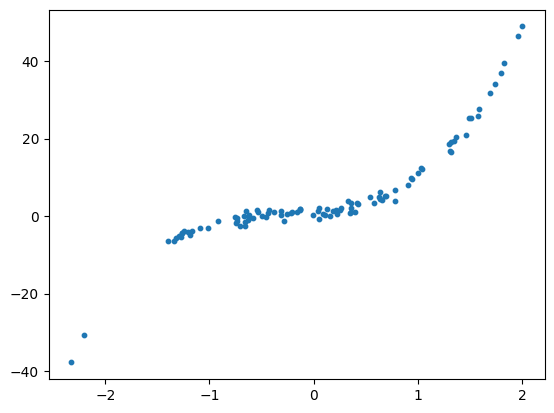

In [61]:
plt.scatter(X, Y, s=10)

In [62]:
columns = [f'X^{i}' for i in range(1, 11)]
print(columns)

d = {name: col for name, col in zip(columns, [X**i for i in range(1, 11)])}
data = pd.DataFrame(d)
data['Y'] = Y
data.head()

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']


,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,Y
0,0.125730,0.015808,0.001988,0.000250,0.000031,0.000004,4.966812e-07,6.244784e-08,7.851581e-09,9.871810e-10,1.809518
1,-0.132105,0.017452,-0.002305,0.000305,-0.000040,0.000005,-7.021528e-07,9.275780e-08,-1.225376e-08,1.618781e-09,1.768637
2,0.640423,0.410141,0.262664,0.168216,0.107729,0.068992,4.418418e-02,2.829655e-02,1.812175e-02,1.160558e-02,4.397629
3,0.104900,0.011004,0.001154,0.000121,0.000013,0.000001,1.397757e-07,1.466249e-08,1.538097e-09,1.613466e-10,0.173065
4,-0.535669,0.286942,-0.153706,0.082336,-0.044105,0.023625,-1.265545e-02,6.779139e-03,-3.631377e-03,1.945217e-03,1.047705


Mallow's $C_p$ is defined as:

$$C_p = \frac{1}{n}(RSS + 2d\hat{\sigma}^2)$$

In [35]:
# Forward selection based on Cp
def nCp(sigma2, estimator, X, Y):
    "Cp statistic. The full model should yield p+1"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    return (RSS + 2*p*sigma2)/n

In [42]:
# Fit model to data
def fit_model(model, X, y):
    # y = data['Y']
    # X = data[columns]
    model_fitted = model.fit(X, y)

    # Compute sigma after fit
    y_pred = model_fitted.predict(X)
    sigma2 = sum((y-y_pred)**2)/X.shape[0]

    Cp = nCp(sigma2, model_fitted, X, y)
    return Cp

In [43]:
y = data['Y']
columns_left = columns[:]
current_columns = []
while len(columns_left) > 0:
#for i in range(0, 11):
    for col in columns_left:
        X = data[current_columns]
        cp = fit_model(LinearRegression(), X, y)
        print(cp)

121.96013726815846
122.16975099257809
1.0476567979625104
1.0490443141107126
1.0510266058173197
1.052875342937621
1.0543959565513235
1.0548313165731977
1.0566133831420825
1.058658178316511


In [18]:
print(model.coef_, model.intercept_)

[ 2.18775759e+00  3.08902903e+00  3.78289062e+00 -4.06550898e-02
  7.93641892e-02  8.95340601e-03 -9.46931190e-03 -9.96131197e-04
  3.47748521e-04  3.79767714e-05] 0.9647956049447055


In [25]:
# Compute sigma after fit
y_pred = model.predict(X)

sigma2 = sum((y-y_pred)**2)/n
sigma2

1.0379001748201089

In [26]:
cp = nCp(sigma2, model, X, y)
cp

1.058658178316511